A notebook to cost a single Trotter step of the 1D Holstein model (see [Sec II.3 here](https://arxiv.org/pdf/2307.06580)) using an all qubit architecture. 

In [14]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter

# Project-specific imports
import c2qa
import c2qa.util as util

import qutip as qt

The one-dimensional version of the Holstein model reads

$$
\hat{H} = - \sum_{\langle i, j \rangle} V f^\dagger_i f_j + \sum_i \omega b^\dagger_i b_i + \sum_i g \omega f^\dagger_i f_i (b^\dagger_i + b_i).
$$
A two-site Holstein model with periodic boundary conditions:
$$
\begin{aligned}
\hat{H} &= -V \Bigl( f^\dagger_1 f_2 + f^\dagger_2 f_1 \Bigr) \\
&\quad + \omega \Bigl( b^\dagger_1 b_1 + b^\dagger_2 b_2 \Bigr) \\
&\quad + g\,\omega \Bigl[ f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) + f^\dagger_2 f_2 \left( b^\dagger_2 + b_2 \right) \Bigr].
\end{aligned}
$$.

We use a Jordan-Wigner encoding for fermions and a Fock binary encoding for the local bosonic degrees of freedom. In the JW encoding, each lattice site (or mode) is represented by one qubit, where $| 0 \rangle$ indicates an empty site and $| 1 \rangle$ indicates an occupied site.
For the bosonic mode at each site, we truncate the Hilbert space to $n_{\text{max}}$, so that the possible bosonic occupation numbers range from 0 to $n_{\text{max}}$. A binary encoding of this truncated Fock space requires $\lceil \log_2(n_{\text{max}}+1) \rceil$ qubits per site.
So in total, we require $N (\log_2(n_{\text{max}}+1) + 1)$ qubits.

We first create the two-site Hamiltonian matrix below.

In [ ]:
def holstein_hamiltonian(v=1.0, omega=1.0, g=1.0, N_b=7):
    
    N_b = N_b + 1 #cutoff + 1 is hilbert space total dims
    
    I_f = qt.qeye(2)
    
    # Define the lowering operator for fermions
    f1 = qt.tensor(qt.destroy(2), I_f)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2)) #JW string
    
    # Each bosonic mode is truncated to N_b
    I_b = qt.qeye(N_b)
    
    # [fermion, fermion, mode 1, mode 2]
    f1_tot = qt.tensor(f1, I_b, I_b)  
    f2_tot = qt.tensor(f2, I_b, I_b)  
    
    # Number operators for the fermions
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    # bosons
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    # Now embed into the full Hilbert space
    b1_tot = qt.tensor(I_f, I_f, b1, I_b)  # mode 1
    b1_dag_tot = b1_tot.dag()
    b2_tot = qt.tensor(I_f, I_f, I_b, b2)  # mode 2
    b2_dag_tot = b2_tot.dag()
    
    H_hop = -v * (f1_tot.dag() * f2_tot + f2_tot.dag() * f1_tot) # Hopping term
    H_phonon = omega * (b1_dag_tot * b1_tot + b2_dag_tot * b2_tot) # Boson "on-site potential"
    H_int = g * omega * (n1_tot * (b1_tot + b1_dag_tot) + n2_tot * (b2_tot + b2_dag_tot)) #fermion boson coupling
    H_total = H_hop + H_phonon + H_int

    return H_total

To get a rough estimate for the number of non-Clifford gates, we note that exponentiating a Pauli string (using the CNOT staircase method) requires just a single non-Clifford gate—a single-qubit rotation applied after mapping the Pauli string’s eigenvalue to one qubit (see [fig 3 here](https://arxiv.org/pdf/1909.12847)).

Therefore the number of non-Clifford gates will be equal to the number of terms in the Hamiltonian, written as a sum of Pauli strings. We use qiskits `SparsePauliOp` (in a similar spirit to the method in [1909.12847](https://arxiv.org/pdf/1909.12847) who use OpenFermions `QubitOperator`) to convert our Hamiltonian into a sum of Pauli strings, which allows us to count the number of terms.

In [3]:
qubit_counts = range(1, 7)  
cutoff_values = [2**q - 1 for q in qubit_counts]  # cutoffs

analytical_nonclifford_counts_1 = []
analytical_total_qubits = []
total_qubit_counts = []
nonclifford_counts = []

# modes and qubits for total counts plot
num_modes = 2      
ferm_qubits = 2   

for cutoff in cutoff_values:
    hamiltonian_matrix = holstein_hamiltonian(N_b=cutoff).full()
    H = SparsePauliOp.from_operator(Operator(hamiltonian_matrix)) # convert to sum of pauli strings
    
    terms = H.to_list() # terms as a list of tuples: (pauli_string, coefficient)
    
    # Non-Clifford counts is just no. terms
    nonclifford_count = len(terms)
    nonclifford_counts.append(nonclifford_count)
    
    # total qubits required for this cutoff 
    qubits_per_mode = int(np.ceil(np.log2(cutoff + 1)))
    total_qubits = 2 * qubits_per_mode + 2 #2 sites so 2 modes and 2 qubits
    total_qubit_counts.append(total_qubits)

header = (
    f"{'q':3} | {'Cutoff':6} || "
    f"{'Non-Cliffs':11} | "
    f"{'Total Qubits':13}| "
    f"{'2^(q+1)q+2q+3'}"
)
print(header)
print("-" * len(header))

for q, cutoff, non_cliff, tot_qubits in zip(
    qubit_counts,
    cutoff_values,
    nonclifford_counts,
    total_qubit_counts,
):
    print(
        f"{q:3} | {cutoff:6} | "
        f"{non_cliff:11} | "
        f"{tot_qubits:13} | "
        f"{2**(q+1)*q + 2*q + 3}" #actual
    )

q   | Cutoff || Non-Cliffs  | Total Qubits | 2^(q+1)q+2q+3
----------------------------------------------------------
  1 |      1 |           9 |             4 | 9
  2 |      3 |          23 |             6 | 23
  3 |      7 |          57 |             8 | 57
  4 |     15 |         139 |            10 | 139
  5 |     31 |         333 |            12 | 333
  6 |     63 |         783 |            14 | 783


### Generalising for $N$ sties
We saw an exponential scaling for the number of non-clifford operators in terms of the boson cutoff for a fixed $N = 2$ sites. We can now create a general Hamiltonian for $N$ sites and do the same procedure to verify how the the number of non-cliffords scales with the number of sites.

In [4]:
def onsite_boson_term(n_sites = 2, omega = 1, N_b = 7):
    """
    Constructs the onsite boson term
    """
    d_b = N_b + 1 #cutoff + 1

    b = qt.destroy(d_b)   # annihilation operator 
    number_op = b.dag() * b   # number operator
    I = qt.qeye(d_b)             

    # Initialize the total term
    H_boson = 0

    for i in range(n_sites):
        # list of operators where the i-th entry is the number operator,
        # and all other entries are the identity.
        op_list = [number_op if j == i else I for j in range(n_sites)]
        H_i = qt.tensor(*op_list)
        H_boson += H_i

    H_boson = omega * H_boson

    return H_boson


def interaction_term(n_sites = 2, omega = 1, g = 1, N_b= 7):
    """
    """
    d_f = 2            # two-level system per site (empty/occupied)
    d_b = N_b + 1      # bosonic cutoff + 1
    I_f = qt.qeye(d_f)
    I_b = qt.qeye(d_b)

    # Fermionic number operator: n = |1><1|
    n_local = qt.Qobj([[0, 0],
                       [0, 1]])
    
    # Bosonic operators for single mode
    b = qt.destroy(d_b)
    b_dag = b.dag()
    disp_b = b + b_dag  

    # Initialize the total term
    H_total = 0
    
    for i in range(n_sites):
        fermion_op_list = [I_f for _ in range(n_sites)]
        fermion_op_list[i] = n_local
        H_f_i = qt.tensor(*fermion_op_list)
        
        # Build the bosonic displacement operator for site i
        boson_disp_list = [I_b for _ in range(n_sites)]
        boson_disp_list[i] = disp_b
        H_disp_i = qt.tensor(*boson_disp_list)
        
        H_int_i = g * omega * qt.tensor(H_f_i, H_disp_i)
        
        # Add this site's contribution
        H_total += H_int_i
        
    return H_total

def fermionic_hopping_term(n_sites = 2, V = 7):
    """
    Constructs the fermionic hopping term:
    """
    I = qt.qeye(2)
    sigmaz = qt.sigmaz()

    fermion_ops = []
    for i in range(n_sites):
        op_list = []
        for j in range(n_sites):
            if j < i:
                op_list.append(sigmaz)      # Jordan-Wigner string
            elif j == i:
                op_list.append(qt.destroy(2))  # Local annihilation operator
            else:
                op_list.append(I)
        f_i = qt.tensor(*op_list)
        fermion_ops.append(f_i)

    # Now sum the nearest-neighbor hopping terms with periodic boundary conditions
    H_hop = 0
    for i in range(n_sites):
        j = (i + 1) % n_sites
        H_hop += -V * (fermion_ops[i].dag() * fermion_ops[j] + fermion_ops[j].dag() * fermion_ops[i])
    
    return H_hop

In [5]:
def build_full_hamiltonian(n_sites=2, N_b=7, omega=1, g=1, V=7):
    """
    Constructs the full Hamiltonian for a system with n_sites fermionic and bosonic sites.

    """
    # Generate the individual Hamiltonian terms with n_sites
    int_term   = interaction_term(n_sites=n_sites, omega=omega, g=g, N_b=N_b)
    hop_term   = fermionic_hopping_term(n_sites=n_sites, V=V)
    onsite_term = onsite_boson_term(n_sites=n_sites, omega=omega, N_b=N_b)
    
    # Embed the fermionic hopping term into the full Hilbert space.
    boson_identities = [qt.qeye(N_b+1) for _ in range(n_sites)]
    full_hop = qt.tensor(hop_term, *boson_identities)
    
    # Embed the onsite boson term into the full Hilbert space.
    fermion_identities = [qt.qeye(2) for _ in range(n_sites)]
    full_onsite = qt.tensor(*fermion_identities, onsite_term)
    
    # full Hamiltonian
    H_full = full_hop + full_onsite + int_term

    return H_full

In [6]:
# Define column widths
header_fmt = "{:<8} | {:<2} | {:<22} | {:<20}"
row_fmt = "{:<8d} | {:<2d} | {:<22d} | {:<20d}"

print(header_fmt.format("n_sites", "q", "n(q*2^(q)+q+2)+1", "non clifford terms"))
print("-" * 65)

for q in [1, 2]:
    N_b = 2**q - 1
    for n in range(3, 6):
        # Build Hamiltonian 
        H = build_full_hamiltonian(n_sites=n, N_b=N_b)
        H_sparse = SparsePauliOp.from_operator(Operator(H.full()))
        non_clifford = len(H_sparse.to_list())
        print(row_fmt.format(n, q, n * (q * 2**q + q + 2) + 1, non_clifford))


n_sites  | q  | n(q*2^(q)+q+2)+1       | non clifford terms  
-----------------------------------------------------------------
3        | 1  | 16                     | 16                  
4        | 1  | 21                     | 21                  
5        | 1  | 26                     | 26                  
3        | 2  | 37                     | 37                  
4        | 2  | 49                     | 49                  
5        | 2  | 61                     | 61                  


We find, for a single Trotter step, for $N>2$ sites and a cutoff $K = 2^q -1$, the number of non-cliffords scales as $N(q2^q+q+2)+1.$ 


### Scaling Comparison: All-Qubit vs. Hybrid Architecture

We can now compare resource scaling for a first order Trotterization of the Holstein model using our two approaches (see [here](https://github.com/samgodwood/bosonic-qiskit/blob/main/playground/bosonic_operator_costs/holstein/hybrid_holstein.ipynb) for hybrid qubit-oscillator approach). For $N>2$ sites, we have:

- **All-Qubit Encoding:**

  - **Total Qubits:** For the fermions, 1 qubit per lattice site (via Jordan-Wigner, with $|0 \rangle$ for empty and $| 1 \rangle$ for occupied). For the Bosons, truncated Fock space (up to $n_{\text{max}}$) encoded in $\lceil \log_2(n_{\text{max}}+1) \rceil$ qubits per site. Thus, the total for $N$ sties is: $N\left(1 + \lceil \log_2(n_{\text{max}}+1) \rceil\right)$.
  - **Non cliffords (per Trotter step):** scales as $N \left(q \cdot 2^q + q + 2\right) + 1$, where the cutoff is $2^q-1$,.

- **Hybrid Architecture:**
  - **Qubits + Oscillators:** For the fermions, again using 1 qubit per lattice site via Jordan-Wigner (i.e. $N$ qubits). For the bosonic modes, we use 1 oscillator per lattice site. Hence we have $N$ qubits + $N$ oscillators.
  - **Gate Count (per Trotter step):** $8N$ total gates (see below).

Assuming logical all to all qubit connectivity (see page 59 [here](https://arxiv.org/pdf/2407.10381)), a decomposition of the fSim gate uses on average $5$ non clifford rotations (depending on the arguments to fsim). Hence, if we assume oscillator phase rotations, displacements and qubit-oscillator controlled displacements to be native gates, this is a total of $8N$ gates per Trotter step for the hybrid architecture.

So, we plot **Gates vs. Sites** for a single Trotter step, **Hardware Elements vs. Sites** (for the hybrid architecture, this is $N$ qubits and $N$ oscillators, while for the all-qubit case this is total qubits) and finally **Gates vs. Trotter Steps** for a fixed $N = 10$ sites.

*Note:* As mentioned above, the all-qubit gates are non-Cliffords, while the hybrid counts include total gates. For reference, solid lines are all-qubit and dashed are hybrid-qubit oscillator.


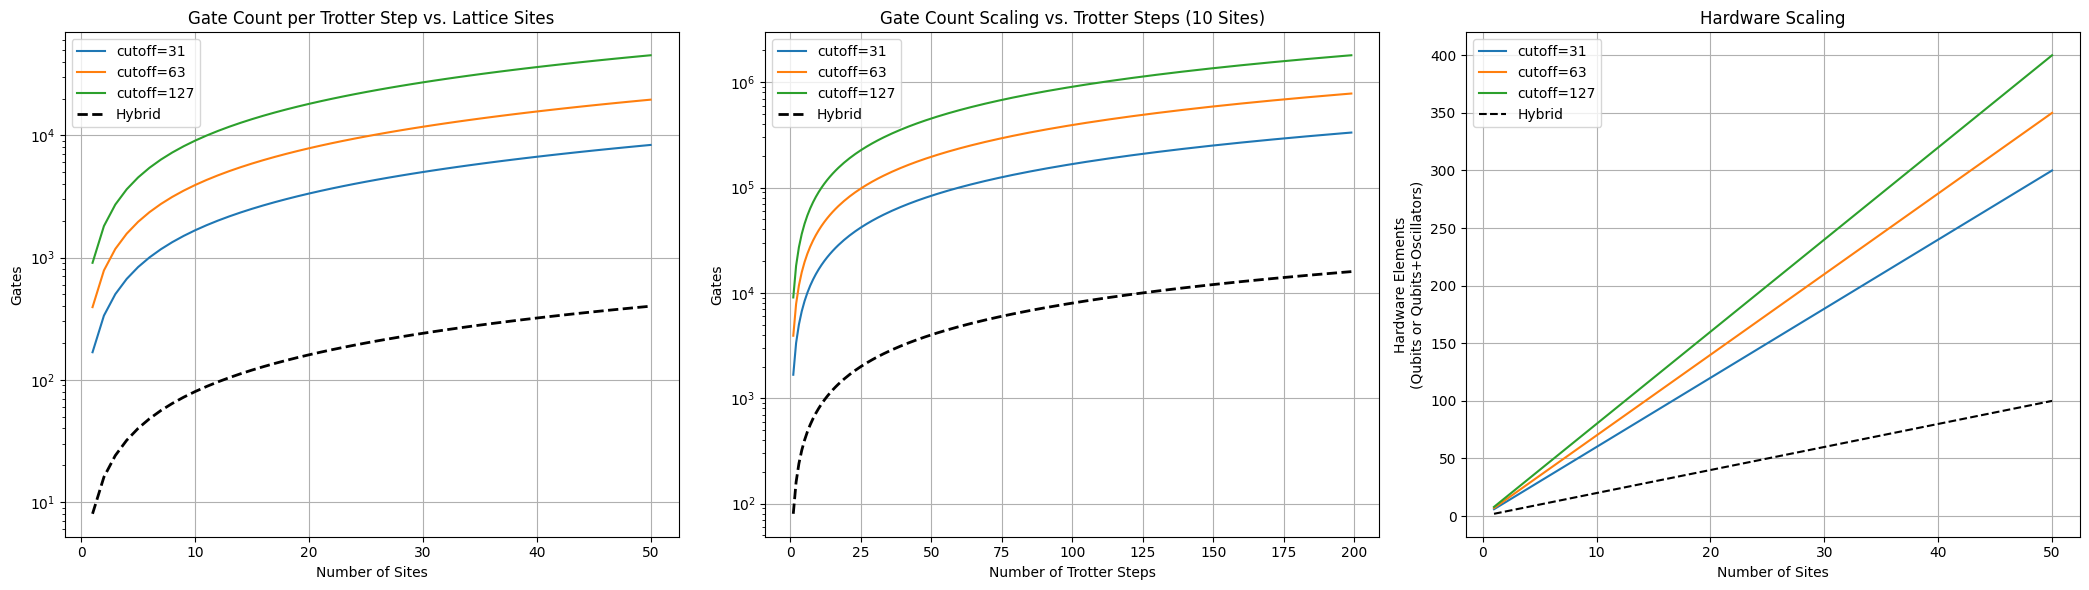

In [28]:
# First two plots parameters
q_values = [5, 6, 7]
cutoffs = [2 ** q - 1 for q in q_values]
N = np.arange(1, 51)

# Third plot parameters
fixed_sites = 10
trotter_steps = np.arange(1, 200)

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# --- First subplot: Non-Clifford Gate Count per Trotter Step vs. Lattice Sites ---
for q, cutoff in zip(q_values, cutoffs):
    axes[0].plot(N, N * (q * (2 ** q) + q + 2) + 1,
                 label=f'cutoff={cutoff}')
axes[0].plot(N, 8 * N, 'k--', linewidth=2, label='Hybrid')
axes[0].set(xlabel="Number of Sites", 
            ylabel="Gates",
            title="Gate Count per Trotter Step vs. Lattice Sites", 
            yscale="log")
axes[0].grid(True)
axes[0].legend()

# --- Second subplot: Total Gate Count vs. Trotter Steps for a 10-Site Lattice ---
for q, cutoff in zip(q_values, cutoffs):
    single_step_gates = fixed_sites * (q * (2 ** q) + q + 2) + 1
    total_gates = trotter_steps * single_step_gates
    axes[1].plot(trotter_steps, total_gates, label=f'cutoff={cutoff}')

hybrid_gate_per_step = 8 * fixed_sites  
axes[1].plot(trotter_steps, trotter_steps * hybrid_gate_per_step, 'k--', linewidth=2, label='Hybrid')
axes[1].set(xlabel="Number of Trotter Steps", 
            ylabel="Gates",
            title="Gate Count Scaling vs. Trotter Steps (10 Sites)", 
            yscale="log")
axes[1].grid(True)
axes[1].legend()

# --- Third subplot: Hardware Resource Scaling vs. Lattice Sites ---
for q, cutoff in zip(q_values, cutoffs):
    axes[2].plot(N, N * (1 + np.log2(cutoff + 1)),
                 label=f'cutoff={cutoff}')
axes[2].plot(N, 2 * N, 'k--', label='Hybrid')
axes[2].set(xlabel="Number of Sites", 
            ylabel="Hardware Elements\n(Qubits or Qubits+Oscillators)",
            title="Hardware Scaling")
axes[2].grid(True)
axes[2].legend()

plt.tight_layout()
plt.show()

### Comparison To Computing Square Root Methods
Along with a Pauli decomposition, we can also compare to the cost using an algorithm in the spirit of [Algorithm 1](https://arxiv.org/abs/2407.10381), but using an optimized square-root calculation on the quantum processor detailed [here](https://arxiv.org/abs/1712.08254).

**For the displacement operator alone** the NRSRA method requires $2\Bigl(\frac{11}{2}q^2 + 23q - 28\Bigr)$ non-Clifford gates and $3q+2$ qubits.

For an initial comparison, and a rough lower bound on the NRSRA method,  we can regard the Holstein model as corresponding to *at least* a displacement operator at each site (arising from the Jordan–Wigner mapping of the coupling term
$$
f^\dagger_1 f_1 \left( b^\dagger_1 + b_1 \right) = (Z_1 + 1)(b_1^\dagger + b_1),
$$
where the term proportional to $Z_1$ generates a conditional displacement gate and the remaining term is a displacement).

Thus, as a **lower bound** for the NRSRA method in the Holstein model for $N$ sites we have:
$$
\text{Non-Cliffords} \gtrsim N \times 2\Bigl(\frac{11}{2}q^2 + 23q - 28\Bigr).
$$
This lower bound does not account for the additional Trotter decomposition required for the fermionic hopping term, the conditional displacement, and the onsite bosonic potential. The number of qubits for this method will always be $N \times (3q + 3)$, arising from $Nq$ qubits to represent the bosons at each site, $N$ qubits to represent the fermions at each site and $N(2q+2)$ ancilla qubits to compute the square root at each site. 

For more details on the algorithm, see [Algorithm 1](https://arxiv.org/abs/2407.10381), Appendix D in [this paper](https://arxiv.org/pdf/2409.03747) and our scaling calculations [here](https://github.com/samgodwood/qualtran-playground/blob/main/displacement/displacement.ipynb).

We also note that we are not currently differentiating between T gates and arbitrary rotations, and are currently just grouping all non-cliffords together.

In [27]:
import pandas as pd
from IPython.display import display
sites_list = [10, 50]
q_values = [5, 6, 7, 8]

rows = []
for fixed_sites in sites_list:
    # Compute cutoff for each q
    cutoffs = [2**q - 1 for q in q_values]
    
    # Pauli Decomp formulas:
    #   Non-Clifford Gates = fixed_sites * (q*(2**q) + q + 2) + 1
    #   Qubits = fixed_sites * (1 + q)
    pd_non_clifford = [fixed_sites * (q * (2**q) + q + 2) + 1 for q in q_values]
    pd_qubits = [fixed_sites * (1 + q) for q in q_values]
    
    # NRSRA formulas:
    #   Non-Clifford Gates = fixed_sites * 2 * ((11/2) * q**2 + 23*q - 28) for a displacement at each site
    #   Qubits = fixed_sites * (3*q + 2 + 1)
    nrsra_non_clifford = [int(round(fixed_sites * 2 * ((11/2) * q**2 + 23*q - 28))) for q in q_values]
    nrsra_qubits = [fixed_sites * (3*q + 2 + 1) for q in q_values]
    
    # Hybrid formulas:
    #   Hybrid Total Gates = fixed_sites * 11
    #   Hybrid Hardware Elements = fixed_sites * 2
    hybrid_gates = fixed_sites * 11
    hybrid_hardware = fixed_sites * 2
    
    for i, q in enumerate(q_values):
        row = {
            'Sites': fixed_sites,
            'q': q,
            'Cutoff': cutoffs[i],
            'Pauli Decomp Non-Clifford Gates': pd_non_clifford[i],
            'NRSRA Non-Clifford SQRT Gates': nrsra_non_clifford[i],
            'Hybrid Total Gates': hybrid_gates,
            'Pauli Decomp Qubits': pd_qubits[i],
            'NRSRA Qubits': nrsra_qubits[i],
            'Hybrid Hardware Elements': hybrid_hardware
        }
        rows.append(row)

df = pd.DataFrame(rows)
display(df)

,Sites,q,Cutoff,Pauli Decomp Non-Clifford Gates,NRSRA Non-Clifford SQRT Gates,Hybrid Total Gates,Pauli Decomp Qubits,NRSRA Qubits,Hybrid Hardware Elements
0,10,5,31,1671,4490,110,60,180,20
1,10,6,63,3921,6160,110,70,210,20
2,10,7,127,9051,8050,110,80,240,20
3,10,8,255,20581,10160,110,90,270,20
4,50,5,31,8351,22450,550,300,900,100
5,50,6,63,19601,30800,550,350,1050,100
6,50,7,127,45251,40250,550,400,1200,100
7,50,8,255,102901,50800,550,450,1350,100
